## Imports and Preliminaries

In [ ]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import timm
import faiss
import optuna
from PIL import Image
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
from scipy.spatial.distance import cosine
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA


# Select device for computations done using PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")

# Function to display an image tensor
def show_image(img, title=None):
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cpu


## Dataset Class

Builds dataset loaders for all MVTec categories, applying preprocessing and grouping images by their defect type. It then samples a batch from each split (train, test, ground truth) and displays example images using a helper function.

In [ ]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split="train", transform=None, cache=False):
        """
        Args:
            root_dir: Path to MVTec AD dataset root.
            category: Product category (e.g., 'bottle', 'cable', 'capsule').
            split: 'train' or 'test'.
            transform: torchvision transforms.
            cache: If True, images are pre-loaded into RAM for faster epochs.
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.cache = cache

        base_dir = self.root_dir / category / split

        if split == "train":
            img_dirs = [(base_dir / "good", 0, "good")]
        elif split == "test":
            # Each folder inside 'test' is a defect type
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]
        else:
            # ground truth images
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]

        self.image_paths = []
        self.labels = []
        self.defect_types = []

        for folder, lbl, defect in img_dirs:
            for img_path in sorted(folder.glob("*.png")):
                self.image_paths.append(img_path)
                self.labels.append(lbl)
                self.defect_types.append(defect)
                
        self.cached_images = None
        if cache:
            self.cached_images = [
                Image.open(p).convert("RGB") for p in self.image_paths
            ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        defect_type = self.defect_types[idx]

        return img, defect_type

### Create Datasets

In [ ]:
MVTEC_ROOT = "./Dataset"
BATCH_SIZE = 40
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

root_dir = Path(MVTEC_ROOT)

all_categories = [cat.name for cat in root_dir.iterdir() if cat.is_dir()]
print(all_categories)


def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

transform = get_transforms(IMAGE_SIZE)

def build_concat(split):
    datasets = [
        MVTecDataset(MVTEC_ROOT, cat, split=split, transform=transform)
        for cat in all_categories
    ]
    return ConcatDataset(datasets)


train_dataset = build_concat("train")
test_dataset = build_concat("test")
ground_truth_dataset = build_concat("ground_truth")


train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


### Show Dataset Images

TRAINING IMAGES


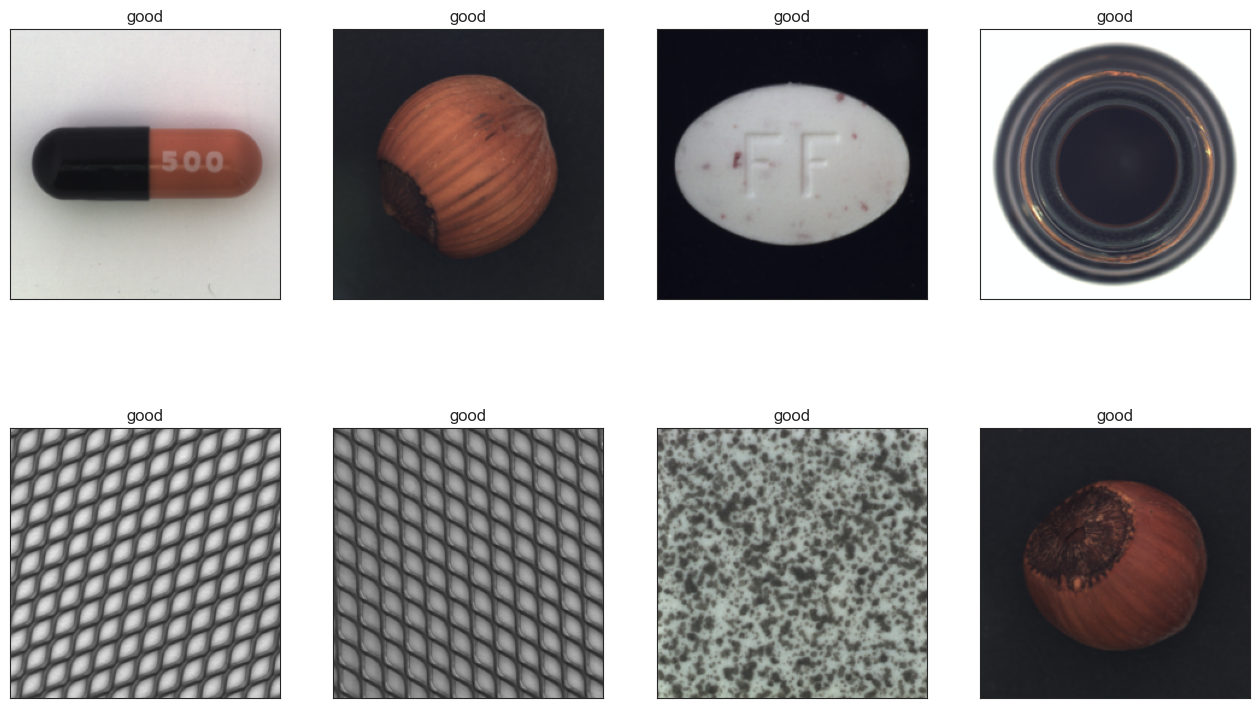

TESTING IMAGES


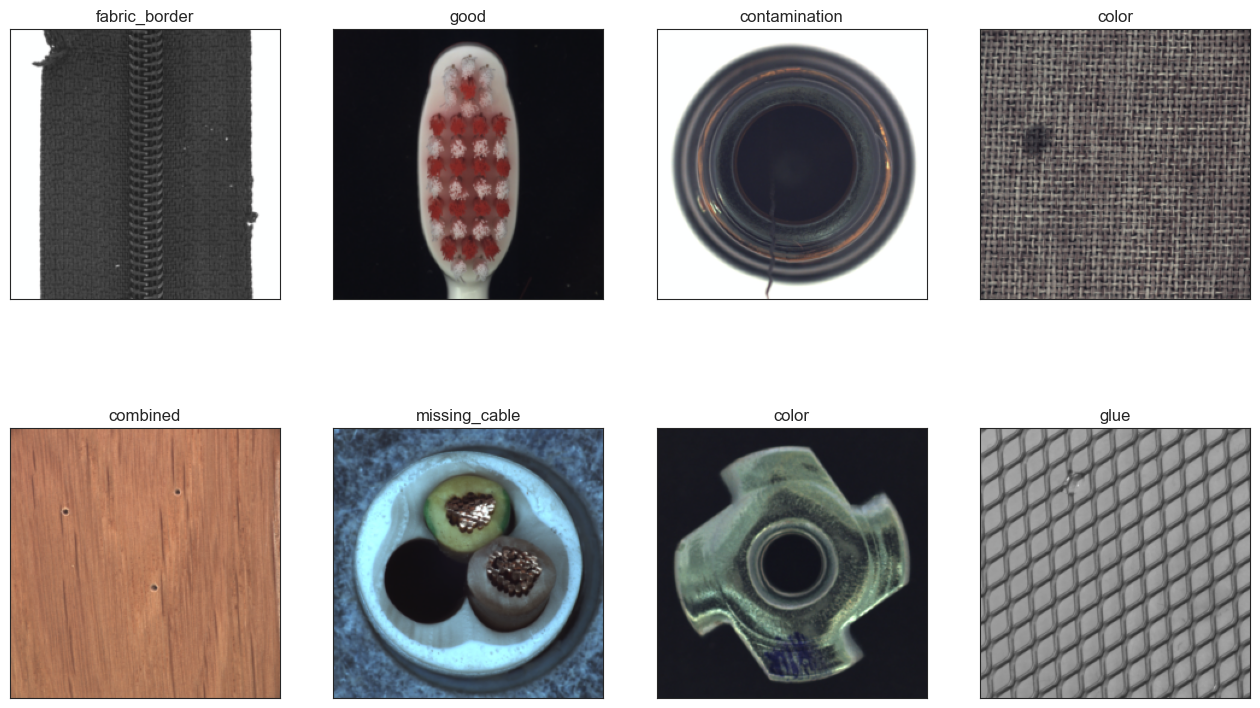

GROUND TRUTH MASKS


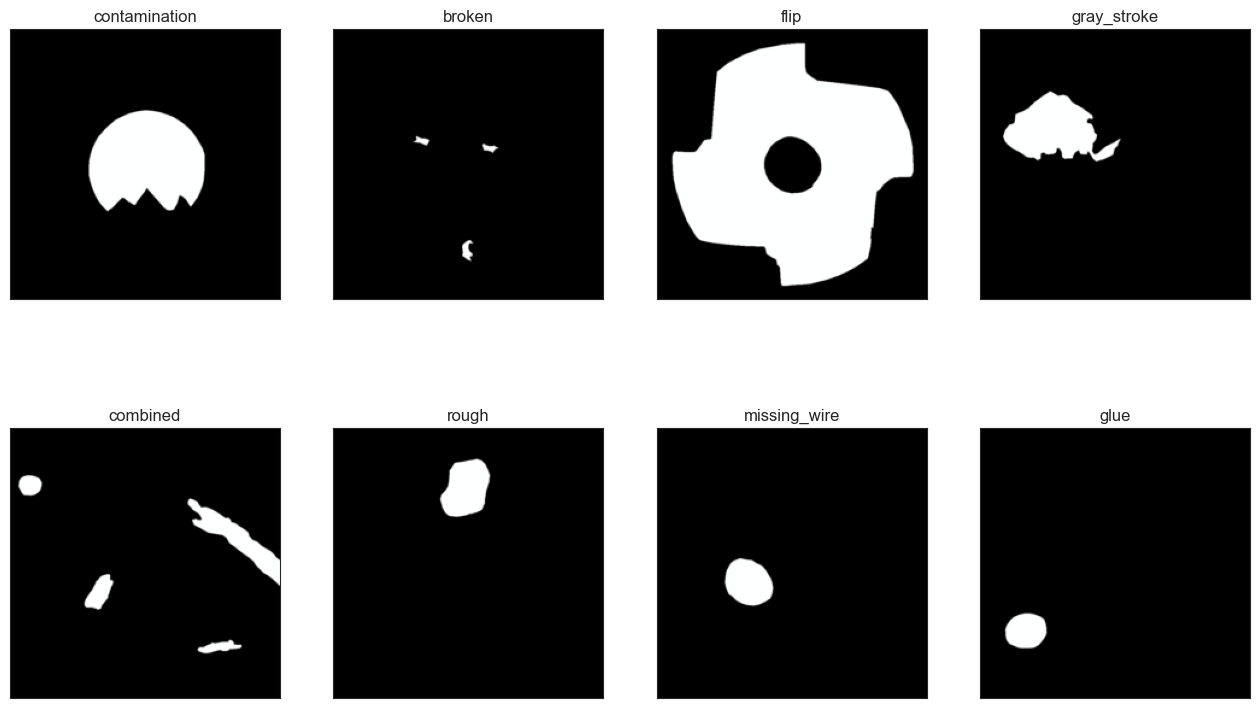

In [14]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))

    with sns.axes_style("white"):
        fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))

    axes = [ax for row in axes for ax in row]

    for j, ax in enumerate(axes[:8]):
        img = images[j]
        label = labels[j]

        plt.sca(ax)
        show_image(img, label)

    plt.show()


train_example_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

test_example_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)

ground_truth_example_loader = DataLoader(
    dataset=ground_truth_dataset, batch_size=8, shuffle=True
)
print("TRAINING IMAGES")
show_dataset_examples(train_example_loader)
print("TESTING IMAGES")
show_dataset_examples(test_example_loader)
print("GROUND TRUTH MASKS")
show_dataset_examples(ground_truth_example_loader)

## Embed training features using mean pooling

Extracts feature embeddings from a pretrained vision model and saves them in compressed form so they can be reused without recomputing. It also provides utility functions to load and preprocess these embeddings efficiently for downstream anomaly-detection experiments.

### Constants

In [15]:
EMBEDDING_FILE_EXT = "embeddings.npz"
PATCH_EMBEDDINGS_FOLDER = "./patch_embeddings"
POOLED_EMBEDDINGS_FOLDER = "./pooled_embeddings"
MODEL_URL = "vit_small_patch16_dinov3_qkvb.lvd1689m"

POOLED_TRAIN_PATH = f"{POOLED_EMBEDDINGS_FOLDER}/train_{EMBEDDING_FILE_EXT}"
POOLED_TEST_PATH = f"{POOLED_EMBEDDINGS_FOLDER}/test_{EMBEDDING_FILE_EXT}"
PATCH_TRAIN_PATH = f"{PATCH_EMBEDDINGS_FOLDER}/train_{EMBEDDING_FILE_EXT}"
PATCH_TEST_PATH = f"{PATCH_EMBEDDINGS_FOLDER}/test_{EMBEDDING_FILE_EXT}"

NUM_PATCHES_PER_IMAGE = 196

### Compressed Embeddings

In [ ]:
def save_embeddings_compressed(embeddings, save_path, dataset_name="train"):
    """
    Args:
        embeddings: List of (embedding, label) tuples
        save_path: Directory to save files
        dataset_name: Base name for the files
    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    emb_arrays = np.array([emb for emb, _ in embeddings])
    labels = np.array([label for _, label in embeddings])

    npz_path = save_path / f"{dataset_name}_{EMBEDDING_FILE_EXT}"
    np.savez_compressed(npz_path, embeddings=emb_arrays, labels=labels)

    print(f"Compressed embeddings saved to: {npz_path}")
    print(f"File size: {os.path.getsize(npz_path) / 1e6:.2f} MB")

    return npz_path


def load_embeddings_compressed(npz_path, n_register_tokens=0):
    """
    Load embeddings from compressed numpy format.

    Args:
        npz_path: Path to .npz file

    Returns:
        embeddings: List of (embedding_array, label) tuples
    """
    print(f"Loading compressed embeddings from: {npz_path}")

    data = np.load(npz_path)
    emb_arrays = data["embeddings"]
    labels = data["labels"]

    # Remove register tokens from each image when using patch embeddings
    if n_register_tokens > 0:
        emb_arrays = emb_arrays[:, n_register_tokens:, :]

    embeddings = [(emb_arrays[i], labels[i]) for i in range(len(labels))]

    print(
        f"Loaded {len(embeddings)} embeddings with shape {emb_arrays.shape[1:]} per image"
    )

    return embeddings

### Create the embeddings

In [ ]:
def embed_and_save_features(
    dataloader, split, embedding_folder, model_url=MODEL_URL, device="cuda"
):
    """
    Efficient, stable DINOv3 patch embedding extractor.
    Uses mean pooling over patch tokens → 384-dim embeddings.
    """
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):

            images = images.to(device)

            feats = model.forward_features(images)

            if isinstance(feats, dict):
                x = feats.get("x_norm")  
            else:
                x = feats

            emb = x.mean(dim=1)

            emb = emb.cpu().numpy()

            for i, label in enumerate(labels):
                lbl = label.item() if isinstance(label, torch.Tensor) else label
                embeddings.append((emb[i], lbl))

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx+1} batches")

    save_embeddings_compressed(
        embeddings=embeddings, dataset_name=split, save_path=embedding_folder
    )
    return embeddings

In [18]:
embeddings_train = (
    load_embeddings_compressed(POOLED_TRAIN_PATH)
    if os.path.exists(POOLED_TRAIN_PATH)
    else embed_and_save_features(
        train_loader, "train", embedding_folder=POOLED_EMBEDDINGS_FOLDER
    )
)

embeddings_test = (
    load_embeddings_compressed(POOLED_TEST_PATH)
    if os.path.exists(POOLED_TEST_PATH)
    else embed_and_save_features(
        test_loader, "test", embedding_folder=POOLED_EMBEDDINGS_FOLDER
    )
)

Loading compressed embeddings from: ./pooled_embeddings/train_embeddings.npz
Loaded 3629 embeddings with shape (384,) per image
Loading compressed embeddings from: ./pooled_embeddings/test_embeddings.npz
Loaded 1725 embeddings with shape (384,) per image


In [ ]:
def load_embeddings_only(path, max_samples=None):
    data = np.load(path, allow_pickle=True)

    if "embeddings" in data:
        X = data["embeddings"]
        y = data.get("labels", None)
    else:
        pairs = data["arr_0"]
        X = np.stack([e for e, _ in pairs])
        y = np.array([l for _, l in pairs])

    if max_samples is not None:
        X = X[:max_samples]
        if y is not None:
            y = y[:max_samples]

    return X, y

## Visualize Mean Pooled Embeddings Using PCA

first visualizes the global structure of the pooled train embeddings using PCA, creating a 2D scatter plot where points can be colored by label. Then recomputes Vision Transformer embeddings per category (train + test), reduces them with PCA, and plots subplots that show how “good” and anomalous samples distribute in feature space for each selected category.

### All Categories

In [ ]:
def visualize_pca(embeddings, labels=None, title="PCA visualization"):

    embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)

    pca = PCA(n_components=2)
    Xp = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))

    if labels is None:
        plt.scatter(Xp[:, 0], Xp[:, 1], s=8, alpha=0.7)
    else:
        labels = labels.astype(str)
        for lbl in np.unique(labels):
            idx = labels == lbl
            plt.scatter(
                Xp[idx, 0],
                Xp[idx, 1],
                s=10,
                alpha=0.7,
                label=lbl,
            )
        plt.legend()

    var = pca.explained_variance_ratio_ * 100
    plt.xlabel(f"PC1 ({var[0]:.1f}%)")
    plt.ylabel(f"PC2 ({var[1]:.1f}%)")
    plt.title(title)
    plt.grid(True)
    plt.show()

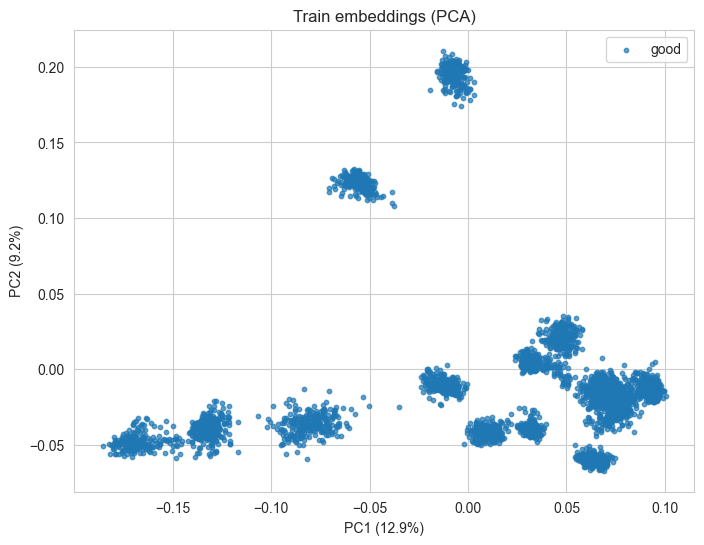

In [21]:
X_test, y_test = load_embeddings_only(
    POOLED_TRAIN_PATH,
)
visualize_pca(X_test, y_test, "Train embeddings (PCA)")

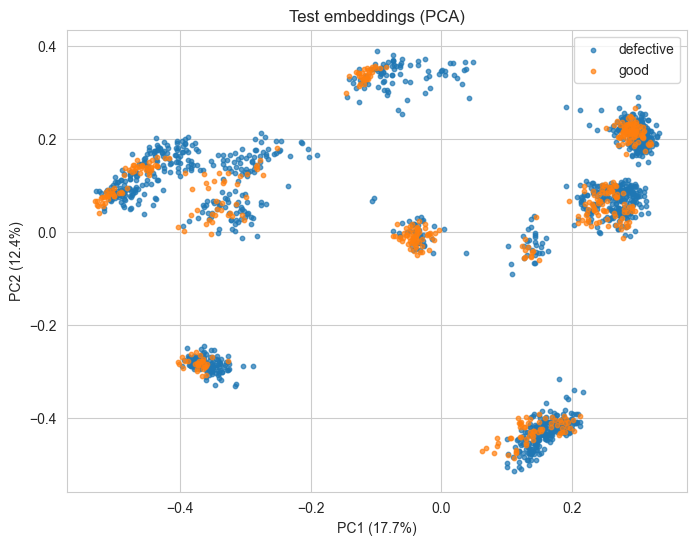

In [22]:
X_test, y_test = load_embeddings_only(
    POOLED_TEST_PATH,
)

y_bin = ["good" if str(label).lower() == "good" else "defective" for label in y_test ]

y_bin = np.array(y_bin)

visualize_pca(X_test, y_bin, "Test embeddings (PCA)")

### Plot per category

To visualize the embeddings per category, with the way the code is currently set up, we have to remake the embeddings, this is fine as we will only run this once to get the visualizations. We want to plot per category too as this allows PCA to happen with regards to the feature maps of one specific category, rather than all the categories combined.

In [17]:
base_model = timm.create_model(MODEL_URL, pretrained=True).to("cpu")
base_model.eval()


# =============== DATA HELPERS ===============

def get_category_loader(category, split):
    """
    Returns a DataLoader for one category and one split ('train' or 'test').

    Expects MVTec-style folder layout:
        Dataset/category/train/...
        Dataset/category/test/...
    """
    dataset = MVTecDataset(
        root_dir=MVTEC_ROOT,
        category=category,
        split=split,
        transform=transform,
        cache=False
    )
    loader = DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )
    return loader


def embed_category_all_splits(category, model):
    """
    Loads ALL images for a category from BOTH:
      - split='train' (good images)
      - split='test'  (good + anomalous images)

    Returns:
        embeddings: np.ndarray of shape (N, D)
        labels:     np.ndarray of defect_type strings (e.g. 'good', 'scratch', ...)
    """
    all_embs = []
    all_labels = []

    with torch.no_grad():
        for split in ["train", "test"]:
            loader = get_category_loader(category, split=split)

            for images, defect_types in loader:
                images = images.to("cpu")

                feats = model.forward_features(images)
                # For DINOv3 ViT in timm, features are usually in dict with key "x_norm"
                if isinstance(feats, dict):
                    x = feats.get("x_norm")
                else:
                    x = feats

                # Max over patch dimension → single embedding per image
                emb = x.mean(dim=1)  # (B, D)
                all_embs.append(emb.cpu().numpy())
                all_labels.extend(defect_types)

    embeddings = np.concatenate(all_embs, axis=0)
    labels = np.array(all_labels)

    return embeddings, labels


def plot_pca_subplots(categories, model):
    """
    For each category in `categories`, load ALL train+test images,
    compute embeddings, do PCA to 2D, and plot them as subplots.

    Good images:      label == "good"
    Anomalous images: label != "good"
    """
    n = len(categories)
    if n == 0:
        print("No categories provided.")
        return

    # Arrange subplots in 2 columns
    cols = 2 if n > 1 else 1
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    if n == 1:
        axes = np.array([axes])  # make it iterable

    axes = axes.flatten()

    for idx, category in enumerate(categories):
        ax = axes[idx]

        print(f"Processing category: {category}")
        embeddings, labels = embed_category_all_splits(category, model)

        if embeddings.shape[0] < 2:
            ax.set_title(f"{category} – not enough samples for PCA")
            ax.axis("off")
            continue

        # good vs anomalous
        is_good = labels == "good"
        is_anom = labels != "good"

        # PCA → 2D
        pca = PCA(n_components=2, random_state=0)
        embs_2d = pca.fit_transform(embeddings)

        # Plot good images
        if np.any(is_good):
            ax.scatter(
                embs_2d[is_good, 0],
                embs_2d[is_good, 1],
                alpha=0.6,
                label="good"
            )

        # Plot anomalous images
        if np.any(is_anom):
            ax.scatter(
                embs_2d[is_anom, 0],
                embs_2d[is_anom, 1],
                alpha=0.6,
                label="anomalous"
            )

        ax.set_title(f"{category} – PCA (train+test)")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.legend()
        ax.set_aspect("equal")

    # Hide any unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


Processing category: bottle


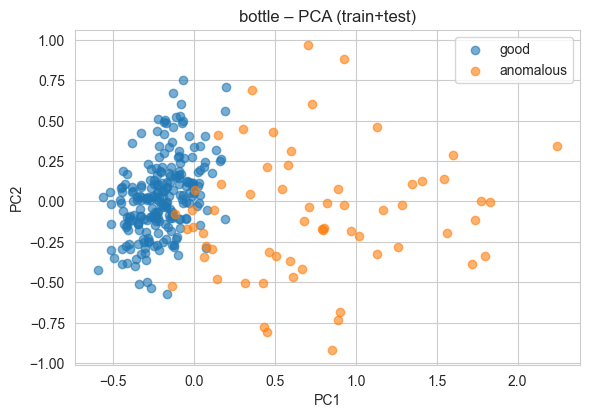

In [18]:
# Uncomment to plot all categories, and comment the next line
# plotted_categories = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut", "pill", "screw", "tile", "toothbrush", "transistor", "zipper"]

plotted_categories = ["bottle"] # For quick testing, only plot "bottle"
plot_pca_subplots(plotted_categories, base_model)

## Save and Study Patch Embeddings

Extracts patch-level embeddings from a pretrained ViT for every image in the train and test loaders, concatenates them, and saves them as compressed .npz files so they can later be reloaded instead of recomputed. When running, either loads precomputed patch embeddings (optionally stripping register tokens) or, if those files don’t exist, computes and saves them first.

In [23]:
def extract_patch_embeddings(dataloader, split, model_url=MODEL_URL):
    """
    Extract patch embeddings for all images in a dataloader.
    Returns: patches_embeddings [N_images, N_patches, D], labels [N_images]
    """
    model = timm.create_model(model_url, pretrained=True)
    model.eval().to(device)

    grid_size = model.patch_embed.grid_size
    print(grid_size)

    all_patches = []
    all_labels = []
    i = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Get patch features (no CLS token)
            feats = model.forward_features(images)
            if isinstance(feats, dict):
                patch_feats = feats.get("x_norm")  # shape: [B, N_patches, D]
            else:
                patch_feats = feats[:, 1:, :]  # drop CLS token if exists

            patch_feats = patch_feats.cpu().numpy()
            print("patch shape:", patch_feats.shape)
            all_patches.append(patch_feats)
            all_labels.extend(labels)

            print('loaded batch', i)
            i += 1

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.array(all_labels)

    embeddings = [(patch, label) for patch, label in zip(all_patches, all_labels)]

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split, save_path='./NEW_embeddings')
    return all_patches, all_labels

In [24]:
train_data, train_labels = (
    zip(*load_embeddings_compressed(PATCH_TRAIN_PATH, n_register_tokens=4))
    if os.path.exists(PATCH_TRAIN_PATH)
    else extract_patch_embeddings(train_loader, "train")
)

test_data, test_labels = (
    zip(*load_embeddings_compressed(PATCH_TEST_PATH, n_register_tokens=4))
    if os.path.exists(PATCH_TEST_PATH)
    else extract_patch_embeddings(test_loader, "test")
)

Loading compressed embeddings from: ./patch_embeddings/train_embeddings.npz
Loaded 3629 embeddings with shape (196, 384) per image
Loading compressed embeddings from: ./patch_embeddings/test_embeddings.npz
Loaded 1725 embeddings with shape (196, 384) per image


## Use FAISS to set up memory bank and patch-level knn

Flattens all patch embeddings, reduces their dimensionality with PCA, normalizes them, and builds a FAISS index so test patches can be compared to a memory bank of normal patches for kNN-based anomaly detection.

In [ ]:
train_patches = np.stack([np.array(p, dtype=np.float32) for p in train_data])
test_patches = np.stack([np.array(p, dtype=np.float32) for p in test_data])

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Flatten train/test patches to 2D arrays
num_train_images, num_patches_per_image, dim = train_patches.shape
num_test_images = test_patches.shape[0]

train_patches_flat = train_patches.reshape(-1, dim)  # (3629*196, 384)
test_patches_flat = test_patches.reshape(-1, dim)  # (1725*196, 384)

# L2-normalize
faiss.normalize_L2(train_patches_flat)
faiss.normalize_L2(test_patches_flat)

(711284, 384) (338100, 384)


In [ ]:
# use PCA to reduce computation time by reducing dimension of patch embeddings from 384 -> 128
pca_dim = 128
pca = PCA(n_components=pca_dim, whiten=True, svd_solver="randomized")
train_patches_reduced = pca.fit_transform(train_patches_flat)
test_patches_reduced = pca.transform(test_patches_flat)


In [27]:
train_patches_reduced = np.ascontiguousarray(train_patches_reduced, dtype=np.float32)
test_patches_reduced = np.ascontiguousarray(test_patches_reduced, dtype=np.float32)

faiss.normalize_L2(train_patches_reduced)
faiss.normalize_L2(test_patches_reduced)

In [28]:
dim = train_patches_reduced.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(train_patches_reduced) # memory bank

## Compute patch-level distances between train vs train patches and test vs train patches

Runs k-nearest-neighbor search on all patch embeddings, saves or loads the resulting distances, removes self-matches for train patches, and computes an anomaly score for each patch by averaging its kNN distances.

In [29]:
def compute_patch_knn(k, index, patches, save_folder, split):
    distances, indices = index.search(patches, k)
    np.savez_compressed(
        f"{save_folder}/{split}_patch_knn.npz",
        distances=distances,
    )
    return distances, indices

In [ ]:
k = 5 # number of nearest neighbors to retrieve, currently set to 5 for computational efficiency

train_distance_path = f"{PATCH_EMBEDDINGS_FOLDER}/train_patch_knn.npz"
test_distance_path = f"{PATCH_EMBEDDINGS_FOLDER}/test_patch_knn.npz"

if os.path.exists(train_distance_path):
    train_knn_data = np.load(train_distance_path, allow_pickle=True)
    train_distances = train_knn_data[list(train_knn_data.keys())[0]]
    train_indices = train_knn_data[list(train_knn_data.keys())[1]]

else:
    train_distances, train_indices = compute_patch_knn(
        k=k,
        index=index,
        save_folder=PATCH_EMBEDDINGS_FOLDER,
        patches=train_patches_reduced,
        split="train",
    )
# Remove self-match
train_distances = train_distances[:, 1:]
train_indices = train_indices[:, 1:]

if os.path.exists(test_distance_path):
    test_knn_data = np.load(test_distance_path, allow_pickle=True)
    test_distances = test_knn_data[list(test_knn_data.keys())[0]]
    test_indices = test_knn_data[list(test_knn_data.keys())[1]]
else:
    compute_patch_knn(
        k=k,
        index=index,
        save_folder=PATCH_EMBEDDINGS_FOLDER,
        patches=test_patches_reduced,
        split="test",
    )

In [31]:
test_patch_scores = test_distances.mean(axis=1)
train_patch_scores = train_distances.mean(axis=1)

## Visualize heatmaps

Reshapes patch-level anomaly scores into heatmaps, visualizes them for defective and normal images, and then aggregates each heatmap into a single anomaly score per image using either the maximum or mean patch value.

In [32]:
h = w = int(NUM_PATCHES_PER_IMAGE ** (1/2))

test_map = test_patch_scores.reshape(num_test_images, h, w)
train_map = train_patch_scores.reshape(num_train_images, h, w)

### Compare anomalous heatmap with ground truth pixel mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


(-0.5, 223.5, 223.5, -0.5)

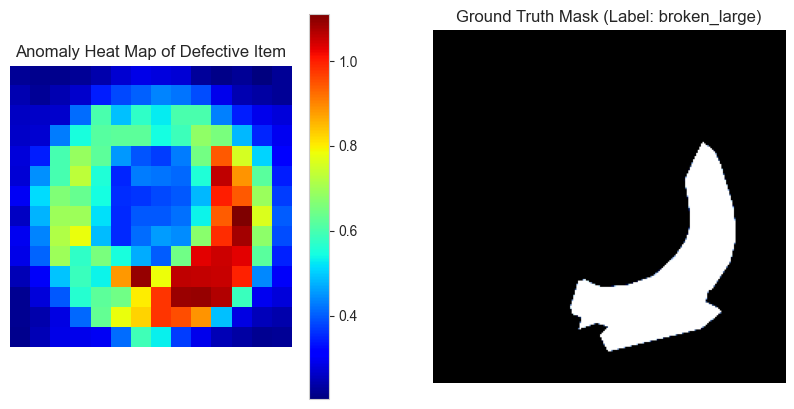

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im = axes[0].imshow(test_map[0], cmap="jet")
axes[0].set_title("Anomaly Heat Map of Defective Item")
fig.colorbar(im, ax=axes[0])
axes[0].axis("off")

img, label = ground_truth_example_loader.dataset[0]
img = img.permute(1, 2, 0).cpu().numpy()
axes[1].imshow(img)
axes[1].set_title(f"Ground Truth Mask (Label: {label})")
axes[1].axis("off")

### Compare heatmap of anomalous image with good image of the same category

(-0.5, 13.5, 13.5, -0.5)

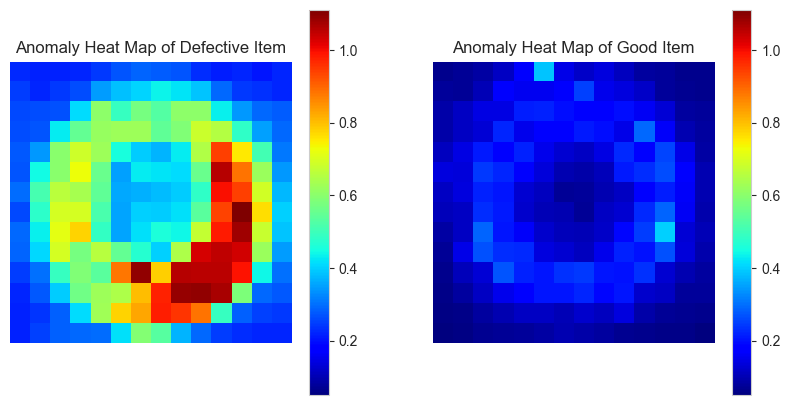

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

anomalous_image_test = test_map[0]
train_image_test = train_map[0]

vmin = min(anomalous_image_test.min(), train_image_test.min())
vmax = max(anomalous_image_test.max(), train_image_test.max())

im_defective = axes[0].imshow(anomalous_image_test, cmap="jet", vmin=vmin, vmax=vmax)
axes[0].set_title("Anomaly Heat Map of Defective Item")
fig.colorbar(im_defective, ax=axes[0])
axes[0].axis("off")

im_good = axes[1].imshow(train_image_test, cmap="jet", vmin=vmin, vmax=vmax)
axes[1].set_title("Anomaly Heat Map of Good Item")
fig.colorbar(im_good, ax=axes[1])
axes[1].axis("off")

In [35]:
test_image_scores_max = test_map.max(axis=(1, 2))  # max over all patches per image
test_image_scores_mean = test_map.mean(axis=(1, 2))  # mean over all patches per image
print(test_image_scores_max)

[1.1107     1.0043377  1.1485412  ... 0.588246   0.78442645 0.81220436]


In [36]:
train_image_scores_max = train_map.max(axis=(1, 2))
train_image_scores_mean = train_map.mean(axis=(1, 2))
print(train_image_scores_max)

[0.39901772 0.3528969  0.34588113 ... 0.43306088 0.31742382 0.25721404]


## Patch level optuna study for kNN percentile threshold

Uses Optuna to search for the best percentile-based threshold on training anomaly scores, evaluates that threshold on test images using F1/AUROC/accuracy, and returns the percentile that yields the highest chosen metric.

In [ ]:
def make_objective(eval_param="f1"):
    def objective(trial):

        percentile = trial.suggest_int("percentile", 65, 99)

        threshold = np.percentile(train_image_scores_max, percentile)

        pred_labels = (test_image_scores_max > threshold).astype(int)

        true_labels = np.array(
            [0 if label == "good" else 1 for label in test_labels], dtype=int
        )

        if eval_param == "f1":
            return f1_score(true_labels, pred_labels)
        elif eval_param == "auroc":
            return roc_auc_score(true_labels, test_image_scores_max)
        elif eval_param == "accuracy":
            return (pred_labels == true_labels).mean()
        else:
            raise ValueError(f"Unknown eval_param: {eval_param}")

    return objective

In [38]:
eval_param = "f1"
study = optuna.create_study(direction="maximize")
study.optimize(make_objective(eval_param=eval_param), n_trials=200)

print("Best percentile:", study.best_params["percentile"])
print(f"Best {eval_param} score:", study.best_value)

[I 2025-12-03 16:28:46,201] A new study created in memory with name: no-name-6dd23d08-c199-4287-b898-ad8dbddf6dc2
[I 2025-12-03 16:28:46,219] Trial 0 finished with value: 0.8428518103770063 and parameters: {'percentile': 87}. Best is trial 0 with value: 0.8428518103770063.
[I 2025-12-03 16:28:46,226] Trial 1 finished with value: 0.8503597122302158 and parameters: {'percentile': 74}. Best is trial 1 with value: 0.8503597122302158.
[I 2025-12-03 16:28:46,234] Trial 2 finished with value: 0.8398333964407422 and parameters: {'percentile': 90}. Best is trial 1 with value: 0.8503597122302158.
[I 2025-12-03 16:28:46,241] Trial 3 finished with value: 0.8511560693641619 and parameters: {'percentile': 76}. Best is trial 3 with value: 0.8511560693641619.
[I 2025-12-03 16:28:46,246] Trial 4 finished with value: 0.8450704225352113 and parameters: {'percentile': 85}. Best is trial 3 with value: 0.8511560693641619.
[I 2025-12-03 16:28:46,255] Trial 5 finished with value: 0.8462385321100917 and parame

Best percentile: 65
Best f1 score: 0.8542999289267946
